# **RL4AA'25 Challenge Part 2:** Black Box Optimisation

In this notebook you can solve the RL challenge by not using RL, but a black box optimisation algorithm instead. We provide you with a piece of code that breaks out an objective function from inputs to an objective value, and show you how that function can be passed to a simple optimisation algorithm implementation. You may modify either the objective function or the optimisation algorithm, or both, to achieve the best results.

**NOTE:** Please only modify the designated code sections.


In [1]:
import numpy as np
import scipy.optimize
from gymnasium.wrappers import TimeLimit

from src.environments import ea
from src.eval import Study
from src.eval.eval_rl_v3_sim import generate_trials
from src.trial import Trial
from src.wrappers import RecordEpisode

## Implement your black box optimisation

In the following cell you can implement your own black box optimisation solution. Please only modifiy the designated code sections. You may change either the objective function or the optimisation algorithm, or both. You may also change the `config` dictionary below.


In [2]:
# You may change this config to your liking
config = {
    # Setting for incoming beam parameters on reset. Can be `"random"` to generate
    # random parameters or an array of 11 values to set them to a constant value.
    "magnet_init_mode": np.array([10.0, -10.0, 0.0, 10.0, 0.0]),
    # Limit of by how much quadrupole settings may be changed when `action_mode` is set
    # to `"delta"`. This parameter is ignored when `action_mode` is set to `"direct"`.
    "max_quad_setting": 30,
}

In [ ]:
def evaluate_optimizer(
    config: dict,
    write_data: bool = True,
    seed: int | None = None,
    evaluation_name: str = "unnamed",
) -> None:
    """
    Evaluate an optimiser on a set of trials (different incoming beams, quadrupole
    misalignments and screen misalignments).

    :param config: The configuration dictionary.
    :param write_data: Whether to write the episode data to disk.
    :param seed: The seed to use for generating the trials.
    """

    trials = generate_trials(num=20, seed=seed)

    for i, trial in enumerate(trials):
        evaluate_on_trial(i, trial, config, write_data, evaluation_name)


def evaluate_on_trial(
    trial_index: int,
    trial: Trial,
    config: dict,
    write_data: bool = True,
    evaluation_name: str = "unnamed",
) -> None:
    """
    Evaluate an optimser on a single trial.

    :param trial_index: The index of the trial.
    :param trial: The trial to evaluate on.
    :param model: The policy model to evaluate.
    :param config: The configuration dictionary.
    :param write_data: Whether to write the episode data to disk.
    :param evaluation_name: The name of the evaluation. Used as the directory name
        for the evaluation data.
    """

    # Create the environment
    env = ea.TransverseTuning(
        backend="cheetah",
        backend_args={
            "incoming_mode": trial.incoming_beam,
            "max_misalignment": 5e-4,
            "misalignment_mode": trial.misalignments,
            "simulate_finite_screen": False,
        },
        action_mode="direct",
        magnet_init_mode=config["magnet_init_mode"],
        max_quad_setting=config["max_quad_setting"],
        target_beam_mode=np.zeros(4),
        target_threshold=None,
        threshold_hold=5,
        clip_magnets=True,
    )
    env = TimeLimit(env, 150)
    if write_data:
        env = RecordEpisode(
            env,
            save_dir=(f"data/{evaluation_name}/problem_{trial_index:03d}"),
        )

    # Actual optimisation
    observation, info = env.reset()
    x0 = observation["magnets"]

    # vvvvvvvv ONLY MODIFY THE CODE BELOW vvvvvvvv
    def objective_function(x):
        observation, _, _, _, _ = env.step(x)
        mae = np.mean(np.abs(observation["beam"] - observation["target"]))
        return mae

    res = scipy.optimize.minimize(
        objective_function,
        x0,
        method="nelder-mead",
        options={
            "xatol": 1e-8,
            "disp": True,
            "maxfev": env.get_wrapper_attr(
                "_max_episode_steps"
            ),  # Maximum number of function evaluations
        },
    )
    # ^^^^^^^^^ ONLY MODIFY THE CODE ABOVE ^^^^^^^^^

    env.close()

## Evaluate your optimiser

The following code evaluates your implementation. We recommend you give it a useful name. If you fail to do so, some of your old results may be overwritten.


In [4]:
evaluation_name = "nelder_mead"  # <<<<<< Give an appropriate name here

# vvvvvvvv DO NOT MODIFY THE CODE BELOW vvvvvvvv
evaluate_optimizer(
    config=config,
    write_data=True,
    seed=42,
    evaluation_name=evaluation_name,
)

Overwriting existing data recordings at /Users/jankaiser/Documents/DESY/rl4aa25-tutorial/data/nelder_mead/problem_000 folder. Specify a different `save_dir` for the `RecordEpisode` wrapper if this is not desired.


/var/folders/z8/vzg_1dr50gg1zchydp1styc00000gn/T/ipykernel_19912/3764787469.py:75: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  res = scipy.optimize.minimize(


Overwriting existing data recordings at /Users/jankaiser/Documents/DESY/rl4aa25-tutorial/data/nelder_mead/problem_001 folder. Specify a different `save_dir` for the `RecordEpisode` wrapper if this is not desired.
Overwriting existing data recordings at /Users/jankaiser/Documents/DESY/rl4aa25-tutorial/data/nelder_mead/problem_002 folder. Specify a different `save_dir` for the `RecordEpisode` wrapper if this is not desired.
Overwriting existing data recordings at /Users/jankaiser/Documents/DESY/rl4aa25-tutorial/data/nelder_mead/problem_003 folder. Specify a different `save_dir` for the `RecordEpisode` wrapper if this is not desired.
Overwriting existing data recordings at /Users/jankaiser/Documents/DESY/rl4aa25-tutorial/data/nelder_mead/problem_004 folder. Specify a different `save_dir` for the `RecordEpisode` wrapper if this is not desired.
Overwriting existing data recordings at /Users/jankaiser/Documents/DESY/rl4aa25-tutorial/data/nelder_mead/problem_005 folder. Specify a different `s

Now the results are loaded, shown to you and a CSV file is generated at `data/csvs/[evaluation_name].csv`. This file is the one you need to submit to the challenge.


In [5]:
study = Study.load(f"data/{evaluation_name}", name=evaluation_name)

In [6]:
study.evaluate_challenge()

Overwriting existing file data/csvs/nelder_mead.csv
Final MAE: 33 μm
Steps to convergence: 69.0
Sum of magnet changes: 7.41


You can also admire your implementation in action by running the following code:


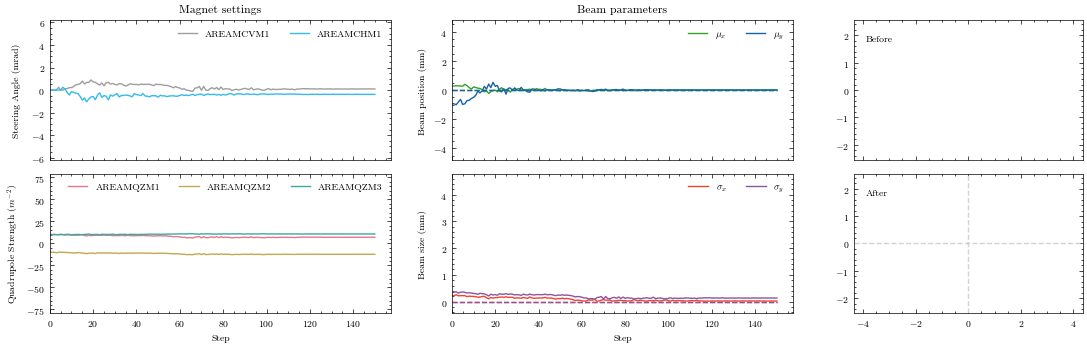

In [7]:
_ = study.episodes[2].plot_summary()

## 🏆 Upload your results to Kaggle

For the chance to win the challenge prize. Go to `data/csvs/` and upload the CSV file via \_"Submit Prediction" to the challenge submission page: https://www.kaggle.com/t/ad56a627d147405fa7b5c8629c8b7cf4
